In [ ]:
#@title **Hugging Face Login**
#@markdown　You need access token of Hugging Face.
!pip -qq install diffusers==0.3.0

!pip -qq install transformers scipy ftfy gradio
!pip -qq install "ipywidgets>=7,<8"

from google.colab import output
output.enable_custom_widget_manager()

from huggingface_hub import notebook_login
notebook_login()

     |████████████████████████████████| 153 kB 28.9 MB/s 
     |████████████████████████████████| 163 kB 72.9 MB/s 
     |████████████████████████████████| 4.9 MB 27.1 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 5.3 MB 58.4 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
     |████████████████████████████████| 84 kB 1.7 MB/s 
     |████████████████████████████████| 212 kB 62.1 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 270 kB 53.3 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 57 kB 5.6 MB/s 
     |████████████████████████████████| 112 kB 68.6 MB/s 
     |████████████████████████████████| 2.3 MB 64.6 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
     |████████████████████████████████| 80 kB 10.1 MB/s 
     |███████████████████████

In [ ]:
#@markdown　Install gradio if absent

!pip install gradio
!pip install diffusers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

{'trained_betas'} was not found in config. Values will be initialized to default values.


Generation loop start.
Generation loop ended. The best individual: 
{'body_hair': [1.0, 1.0, 1.0, 1], 'body_size': [1.0, 0.0, 0.0, 1], 'herd_num': [0.0, 0.0, 1.0, 0], 'eating': [0.0, 0.0, 1.0, 0], 'body_color': [0.0, 0.0, 0.0, 0], 'ferocity': [0.0, 1.0, 1.0, 1]}

seed=3356008392440979


  0%|          | 0/51 [00:00<?, ?it/s]

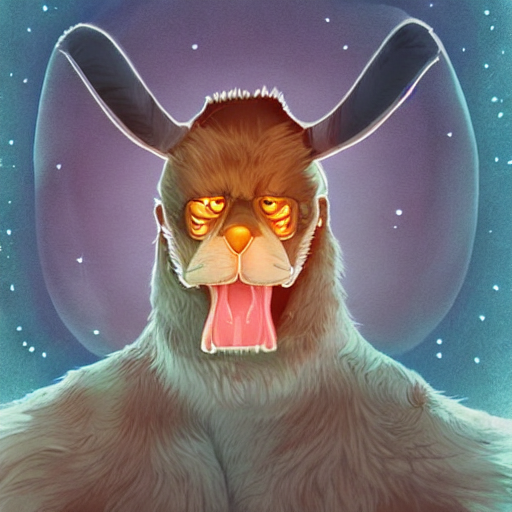

最初の世代: Very Furry Tall Herd of No teeth Lighter skin Ferocious alien from Mars 

seed=2671567575254328


  0%|          | 0/51 [00:00<?, ?it/s]

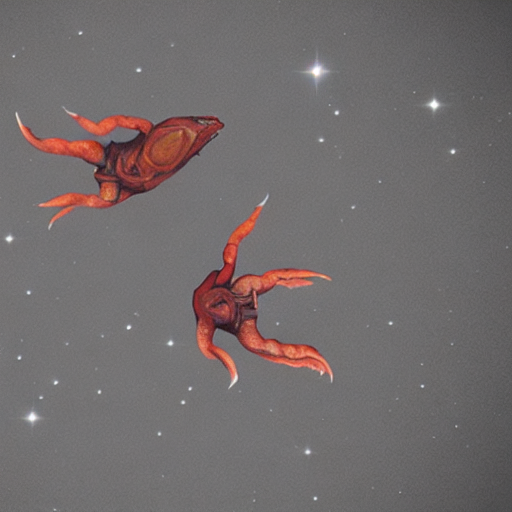

中間の{midle_generation}世代目:   Pair Carnivorous  Gentle alien from Mars 

seed=7531330006035757


  0%|          | 0/51 [00:00<?, ?it/s]

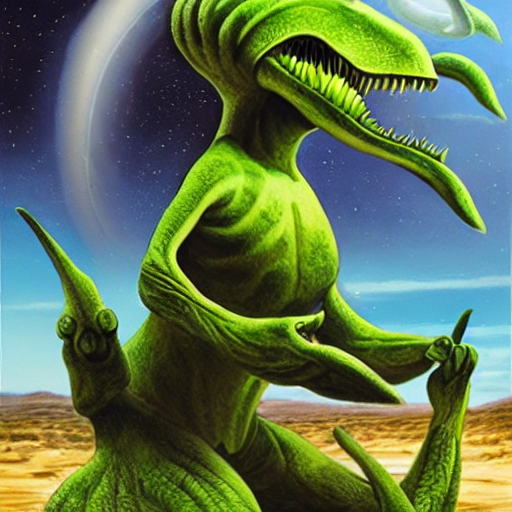

最後の{GENERATIONS}世代目:   Pair Herbivorous  Ferocious alien from Mars 



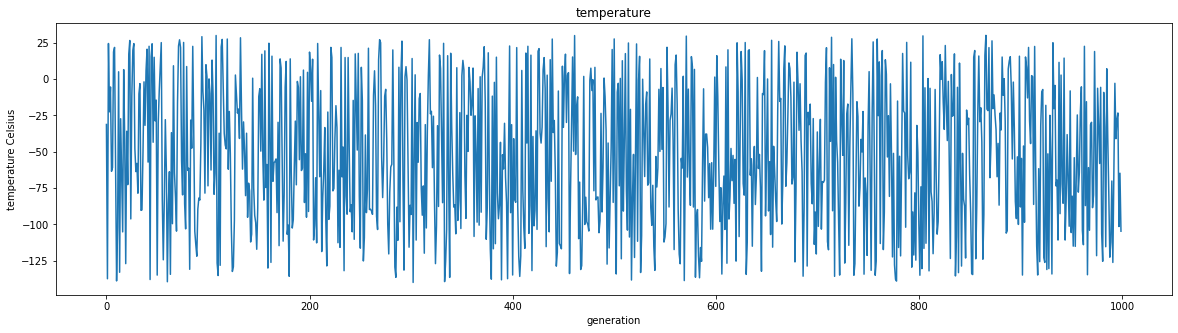

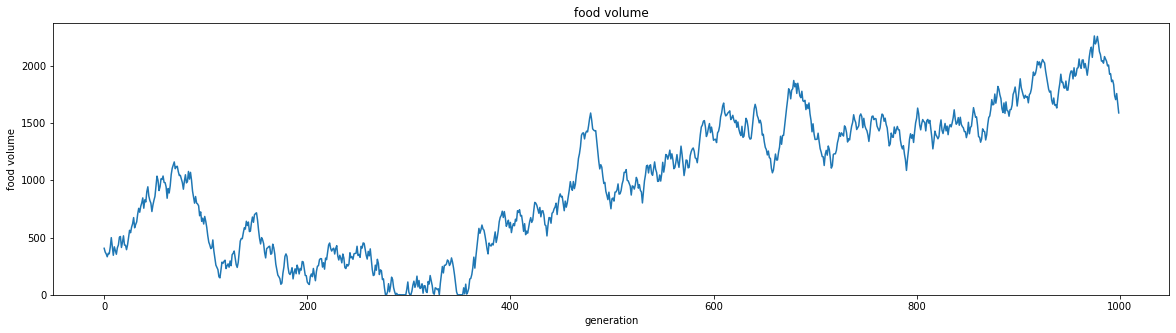

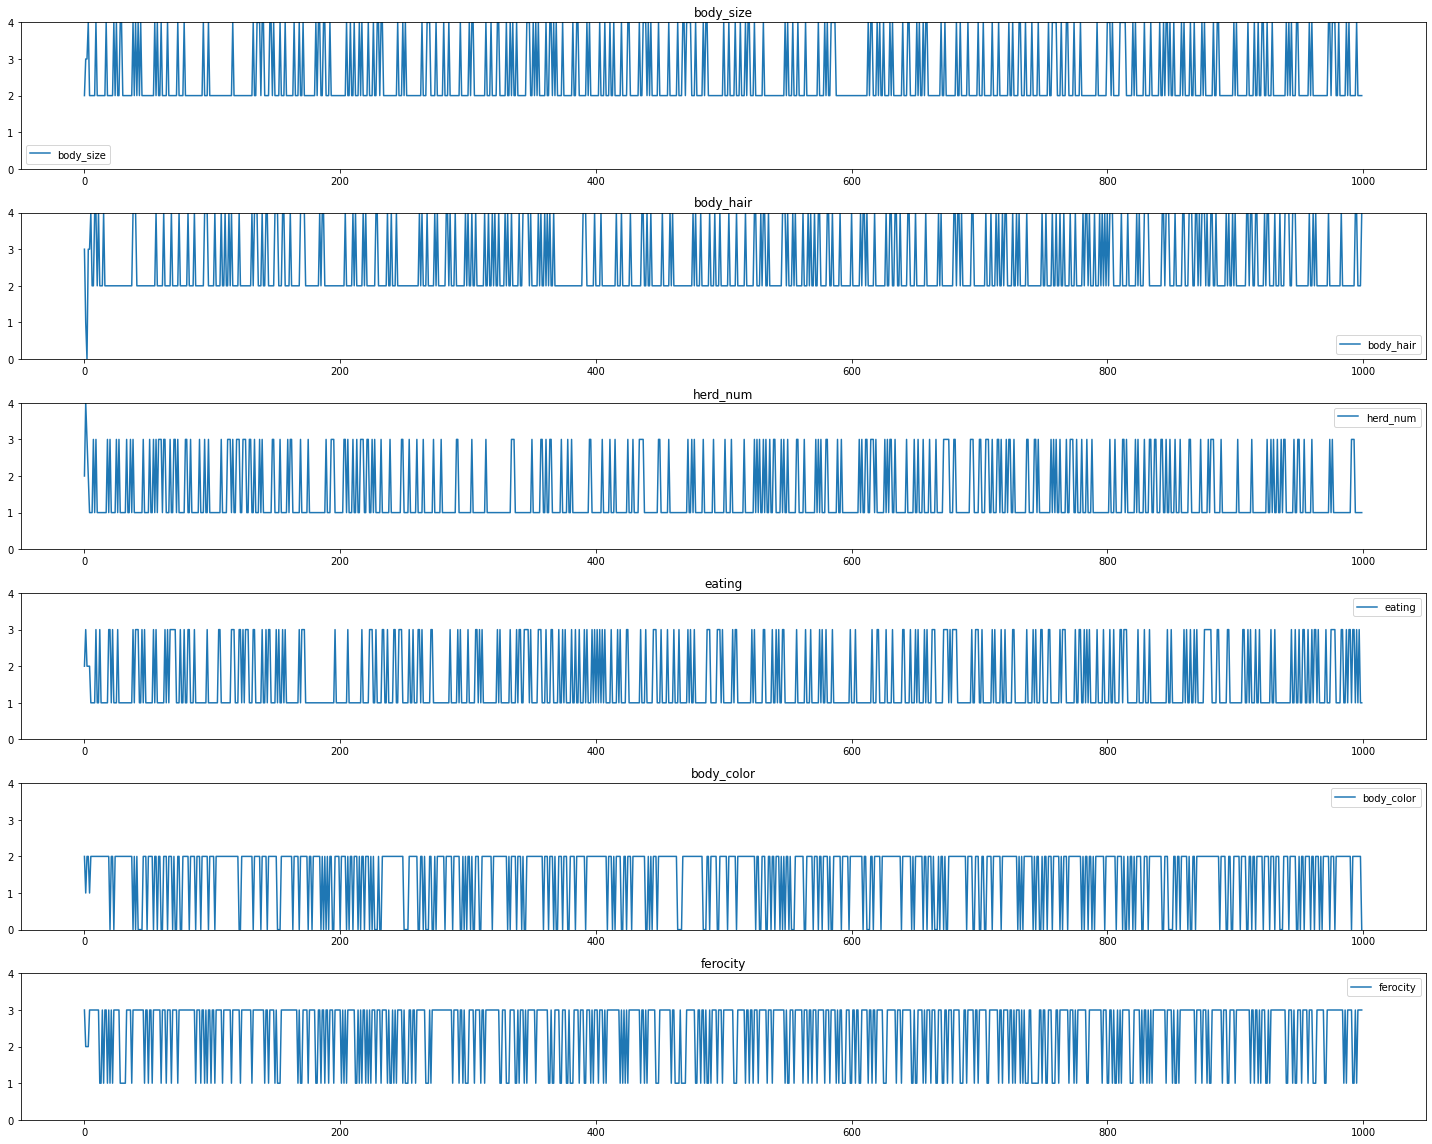

In [ ]:
#@title **Launch App**
# Execute and click URL ex: `Running on public URL: https://xxxx.gradio.app` 

import gradio as gr
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler

import os
import sys

sys.path.append("./")

import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Tuple, Dict, List

from simulation import *

"""
!pip install colab-env -qU
import colab_env
import os
from colab_env import envvar_handler
envvar_handler.envload()
"""

import pprint
import time
import urllib.error
import urllib.request
import requests

#@markdown　Select model 

device = "cuda"
model_id = "CompVis/stable-diffusion-v1-4" #@param ["CompVis/stable-diffusion-v1-4", "hakurei/waifu-diffusion", "naclbit/trinart_stable_diffusion_v2"] {allow-input: true}

if model_id == "CompVis/stable-diffusion-v1-4":
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        revision="fp16",
        torch_dtype=torch.float16,
        use_auth_token=True,
    ).to(device)

if model_id == "hakurei/waifu-diffusion":
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        revision="fp16",
        scheduler=DDIMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            clip_sample=False,
            set_alpha_to_one=False,
        ),
        use_auth_token=True,
    ).to(device)

if model_id == "naclbit/trinart_stable_diffusion_v2":
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        revision="diffusers-60k",
        use_auth_token=True,
    ).to(device)



# Full model
#pipe = StableDiffusionPipeline.from_pretrained(
#    model_id,
#    use_auth_token=True,
#).to(device)


def infer(prompt, num_images, num_inference_steps, guidance_scale_value, width_images, height_images, seed_number):
    generator = torch.Generator(device=device)
    latents = None
    seeds = []

    width = int(width_images)
    height = int(height_images)
    num_images = int(num_images)
    num_inference_steps = int(num_inference_steps)
    seed_number = int(seed_number)

    images = []

    for _ in range(num_images):
        # Get a new random seed, store it and use it as the generator state
        if seed_number < 0:
            seed = generator.seed()
        else:
            seed = seed_number

        print('seed=' + str(seed))
        seeds.append(seed)
        generator = generator.manual_seed(seed)
    
        image_latents = torch.randn(
            (1, pipe.unet.in_channels, height // 8, width // 8),
            generator = generator,
            device = device
        )
        latents = image_latents if latents is None else torch.cat((latents, image_latents))

    for latent in latents:
        with torch.autocast('cuda'):
            image = pipe(
                [prompt],
                width=width,
                height=height,
                guidance_scale=guidance_scale_value,
                num_inference_steps=num_inference_steps,
                latents = latent.unsqueeze(dim=0)
        )['sample']
        images.append(image[0])

    return images

from IPython.display import Image, display

def show_generated_image(words):
  images = infer(words, 1, 50, 7.5, 512, 512, -1)
  display(images[0])


# シード値の固定
SEED = 42
np.random.seed(seed=SEED)
random.seed(SEED)

# パラメーター
POPURATIONS = 500
GENOMS_SIZE = 4 # 遺伝配列 0, 1 のどちらかを要素とした配列のサイズ
GENERATIONS = 1000 # 世代数
CROSSOVER_PB = 0.8 # cross over(交差) する確率
MUTATION_PB = 0.5 # mutation(突然変異)する確率
TOUNAMENT_NUM = 10 # トーナメント方式で競わせる数
MAX_NUM = 4 # fitness の最大値

THREASHOLD_TEMPRETURE = 10
THREASHOLD_FOOD_VOLUME = 3000

# 渡すデータの加工イメージ
# dict 型 {項目(key): 画像生成プログラムに与えるキーワード{value}}
word_dict = {
    "body_size": ["Fingertip sized", "Palm sized", "", "Tall", "Giant"],
    "body_hair": ["Bald", "Smooth", "", "Furry", "Very Furry"],
    "herd_num":	["Lone", "Pair", "", "Herd of", "Swarm of"],
    "eating": ["No teeth", "Herbivorous", "Omnivorous", "Carnivorous", "Fang"],
    "body_color": ["Lightest skin", "Lighter skin", "", "Darker skin", "Darkest skin"],
    "ferocity": ["Peaceful", "Gentle", "", "Ferocious", "Tyrannical"],
}

# create first genetarion
generation = create_generation(POPURATIONS, GENOMS_SIZE)

# アルゴリズムの実行
best, worst = ga_solve(generation)

# 抽出する世代
first_generation = 0
midle_generation = len(best) // 2
last_generation = -1

first_generation_word = get_word_for_image_generate(word_dict, best, first_generation) + " alien from Mars"
middle_generation_word = get_word_for_image_generate(word_dict, best, midle_generation) + " alien from Mars"
last_generation_word = get_word_for_image_generate(word_dict, best, last_generation) + " alien from Mars"

# 抽出する世代のワードを出力
print()

show_generated_image(first_generation_word)
print("最初の世代:", first_generation_word, "\n")

show_generated_image(middle_generation_word)
print("中間の{midle_generation}世代目:", middle_generation_word, "\n")

show_generated_image(last_generation_word)
print("最後の{GENERATIONS}世代目:", last_generation_word, "\n")


